In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [11]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm

import statsmodels.tsa.api as smt
from sklearn import neighbors

from pandas.tseries.offsets import BDay

import pandas as pd
import numpy as np
import scipy

In [220]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '*'     # All 
#exo_filter = 'ES_'  # ES only
exo_filter = 'CL'  # ES Collars (incl Bearish, Bullish, BW and vanilla)

[print(exo) for exo in storage.exo_list(exo_filter)];

CL_BullishCollarBW
CL_BearishCollarBW
CL_CallSpread
CL_PutSpread
CL_ContFut
CL_SMART_Ichimoku_Long
CL_SMART_Ichimoku_VerticalSpread_Bullish
CL_SmartEXO_Ichi_Bullish_Straddle_150Delta
CL_SmartEXO_Ichi_Bullish_Straddle_150Delta_ExpHedged
CL_SmartEXO_Ichi_Bullish_Straddle_150Delta_ExpHedged_test
CL_SmartEXO_Ichi_Bearish_Straddle_BullCall_Spread_0Delta_EXP
CL_SmartEXO_Ichi__BullCall_Spread_Delta_150_EXP
CL_SmartEXO_Ichi_Bearish_Straddle_150Delta
CL_SmartEXO_Ichi_Bearish_Put_Spread_150Delta
CL_SmartEXO_Ichi_Bullish_Straddle_150Delta_ExpHedged_small_BearStraddle
CL_SmartEXO_Ichi_Call_Spread_150Delta_Bi
CL_SmartEXO_Ichi_Put_Spread_150Delta_Bi
CL_SmartEXO_Ichi_Put_Spread_150Delta_Bi_no_neutral
CL_SMART_Ichimoku_Straddle_Bullish
CL_Quandl-EXO-CL-CallSpread
CL_SmartEXO_Bullish_Ichi_Short_Put_Spread_150Delta_Bi
CL_SmartEXO_Bullish_Ichi_Short_Put_Spread_150Delta_Bi_w_Calls


In [115]:
class Strategy_MLRegModel_KNN_pxfeatures(StrategyBase):
    name = 'Strategy_MLRegModel_KNN_pxfeatures'


    def __init__(self, strategy_context):
        # Initialize parent class
        super().__init__(strategy_context)
   
    def calc_entryexit_rules(self, prediction_days, rolling_median_window, rules_index):
        i = 100
        px_ser = self.data.exo
        empty_ser = pd.Series(False, index=px_ser.dropna().index)

        signals_df = pd.DataFrame()

        signals_df['entry_rule'] = empty_ser
        signals_df['exit_rule'] = empty_ser

        while True:
            dataset_df = pd.DataFrame(index=px_ser.dropna().iloc[:i].index)

            px_ser_slice = px_ser[dataset_df.index].rolling(rolling_median_window).median()

            dataset_df['target'] = px_ser_slice.shift(-prediction_days)

            #dataset_df['features_px'] = px_ser_slice
            dataset_df['features_shift1'] = px_ser_slice.shift(1)
            #dataset_df['features_shift2'] = px_ser_slice.shift(2)
            #dataset_df['features_shift3'] = px_ser_slice.shift(3)
            #dataset_df['features_shift5'] = px_ser_slice.shift(5)
            #dataset_df['features_shift10'] = px_ser_slice.shift(10)

            dataset_df['features_ma5'] = px_ser_slice.rolling(5).mean()
            #dataset_df['features_ma10'] = px_ser_slice.rolling(10).mean()
            #dataset_df['features_ma20'] = px_ser_slice.rolling(20).mean()
            #dataset_df['features_ma30'] = px_ser_slice.rolling(30).mean()

            dataset_df['features_relstr5'] = px_ser_slice - px_ser_slice.rolling(5).mean()
            #dataset_df['features_relstr10'] = px_ser_slice - px_ser_slice.rolling(10).mean()
            #dataset_df['features_relstr20'] = px_ser_slice - px_ser_slice.rolling(20).mean()
            #dataset_df['features_relstra30'] = px_ser_slice - px_ser_slice.rolling(30).mean()

            predict_features = dataset_df.filter(like='features').dropna()

            dataset_df.dropna(inplace=True)

            target = dataset_df.target

            features = dataset_df.filter(like='features')

            #model = linear_model.LinearRegression()
            #model = linear_model.ElasticNet()
            #model = linear_model.RANSACRegressor()

            #knn = neighbors.KNeighborsRegressor(5)
            #lr = linear_model.LinearRegression()
            #model = ensemble.BaggingRegressor(base_estimator=None, n_estimators=50)

            #model = linear_model.RANSACRegressor()
            #model = tree.DecisionTreeRegressor(max_depth=4)
            #model = svm.NuSVR()
            #model = ensemble.AdaBoostRegressor(n_estimators=10)
            #model = ensemble.GradientBoostingRegressor()
            #model = ensemble.RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1)
            model = neighbors.KNeighborsRegressor(5, algorithm='auto')
            #model = neighbors.RadiusNeighborsRegressor(5, n_jobs=1, algorithm='auto')

            model.fit(features.iloc[:i], target.iloc[:i])

            prediction_series = pd.Series(model.predict(features.iloc[:i]), 
                                          index=features.iloc[:i].index, name='Prediction') 

            if rules_index == 0:
                if prediction_series[-1] > prediction_series[-2]:
                    signals_df['entry_rule'].ix[px_ser_slice.index[-1]] = True


                    signals_df['exit_rule'].ix[px_ser_slice.index[-1] + BDay(1)] = True


            if rules_index == 1:
                if prediction_series[-1] < prediction_series[-2]:
                    signals_df['entry_rule'].ix[px_ser_slice.index[-1]] = True


                    signals_df['exit_rule'].ix[px_ser_slice.index[-1]+ BDay(1)] = True

            if i >= px_ser.dropna().size:
                break

            i += 1
        
        return signals_df.entry_rule, signals_df.exit_rule
    
    def calculate(self, params=None, save_info=False):
    #
    #
    #  Params is a tripple like (50, 10, 15), where:
    #   50 - slow MA period
    #   10 - fast MA period
    #   15 - median period
    #
    #  On every iteration of swarming algorithm, parameter set will be different.
    #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
    #

        if params is None:
            # Return default parameters
            direction, prediction_days, rolling_median_window, rules_index = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            direction, prediction_days, rolling_median_window, rules_index = params

        # Defining EXO price
        px = self.data.exo
                
        entry_rule, exit_rule = self.calc_entryexit_rules(prediction_days, rolling_median_window, rules_index)

        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness
        swarm_member_name = self.get_member_name(params)

        #
        # Calculation info
        #
        calc_info = None
        if save_info:
            calc_info = {'trailing_stop': trailing_stop}

        return swarm_member_name, entry_rule, exit_rule, calc_info

## Script settings

In [205]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': Strategy_MLRegModel_KNN_pxfeatures,
        'exo_name': 'CL_PutSpread',        # <---- Select and paste EXO name from cell above
        'exo_storage': storage,          
        'opt_params': [
                        #OptParam(name, default_value, min_value, max_value, step)
                        OptParamArray('Direction', [1]),
                        OptParam('n Prediction Days', 1, 4, 10, 2),
                        OptParamArray('Price smoothing rolling median window', [1,5,7]),
                        OptParamArray('Rules index', np.arange(2)),
                        
            ],
    },
    'swarm': {
        'members_count': 2,
        'ranking_class': RankerBestWithCorrel(window_size=-1, correl_threshold=0.5),
        'rebalance_time_function': SwarmRebalance.every_friday,

    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

In [206]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

# Saving results to swarms directory
smgr.save('./swarms/')

### WARNING! Loading swarm from file (don't run next cell if you want new swarm instance)

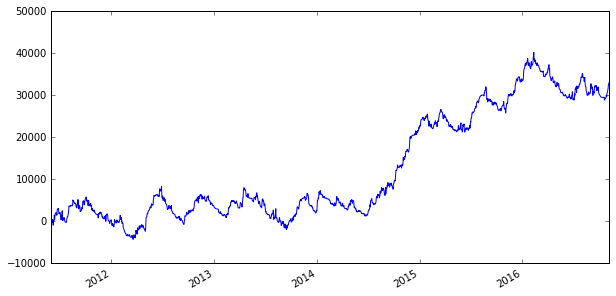

In [207]:
smgr.strategy.data.exo.plot()

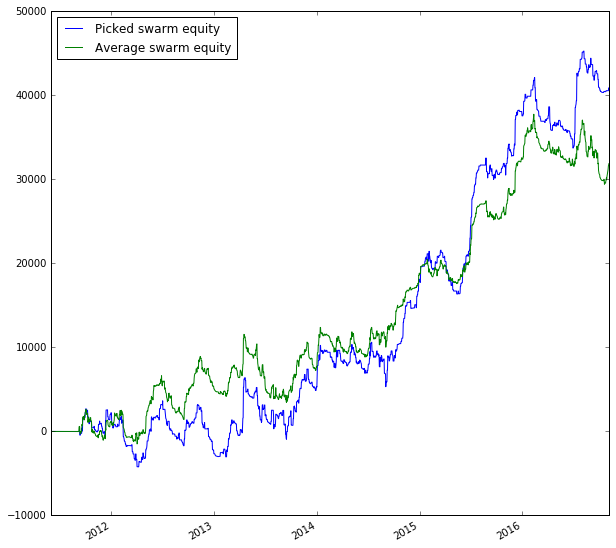

In [208]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

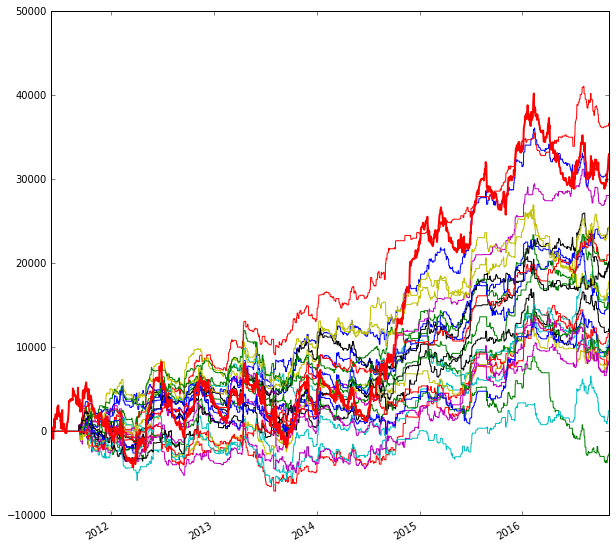

In [209]:
smgr.raw_swarm.plot(legend=False)

(smgr.strategy.data.exo*1).plot(linewidth=2, color='red')

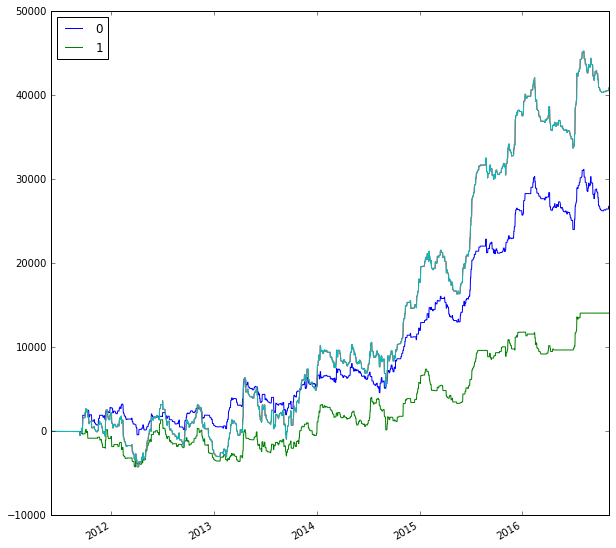

In [210]:
smgr.picked_swarm.plot()

smgr.picked_swarm.sum(1).plot(label='smgr.picked_swarm-sum')
smgr.picked_equity.plot(label='Picked swarm equity')

# Swarm exposure

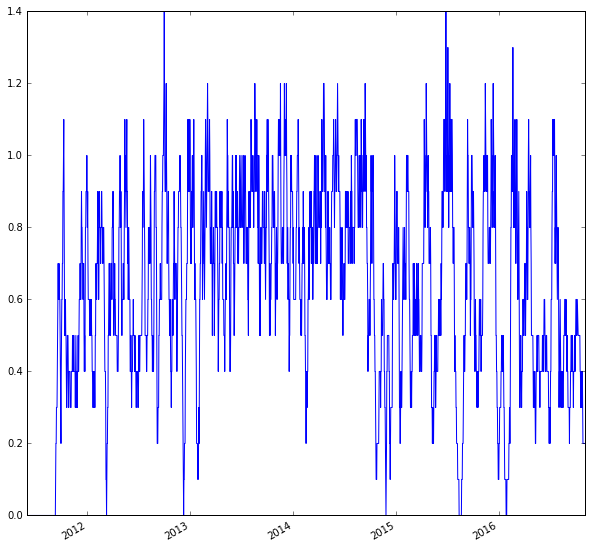

In [211]:
smgr.picked_exposure.sum(axis=1).rolling(10).mean().plot()

# Swarm statistics

#### Non-picked swarm stats

In [212]:
smgr.picked_stats

{'note:Not implemented yet'}

## Exo information

In [213]:
smgr.strategy.exoinfo.exo_info

{'dbdata': {'_id': ObjectId('57f3f38f20bb1d0dfe41fa6a'),
  'calc_date': datetime.datetime(2016, 11, 4, 11, 11, 20, 762000),
  'name': 'CL_PutSpread',
  'position': {'_realized_pnl': 29490.934744650665,
   'positions': {'203183076': {'leg_name': 'opt_otm_leg',
     'qty': -1.0,
     'value': -482.8730176320963},
    '203190526': {'leg_name': 'opt_itm_leg',
     'qty': 1.0,
     'value': 2424.489658735652}}},
  'series': b'\x80\x03cpandas.core.frame\nDataFrame\nq\x00)\x81q\x01}q\x02(X\x04\x00\x00\x00_typq\x03X\t\x00\x00\x00dataframeq\x04X\x05\x00\x00\x00_dataq\x05cpandas.core.internals\nBlockManager\nq\x06)\x81q\x07(]q\x08(cpandas.indexes.base\n_new_Index\nq\tcpandas.indexes.base\nIndex\nq\n}q\x0b(X\x04\x00\x00\x00dataq\x0ccnumpy.core.multiarray\n_reconstruct\nq\rcnumpy\nndarray\nq\x0eK\x00\x85q\x0fC\x01bq\x10\x87q\x11Rq\x12(K\x01K\x01\x85q\x13cnumpy\ndtype\nq\x14X\x02\x00\x00\x00O8q\x15K\x00K\x01\x87q\x16Rq\x17(K\x03X\x01\x00\x00\x00|q\x18NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK?tq\x19b\x

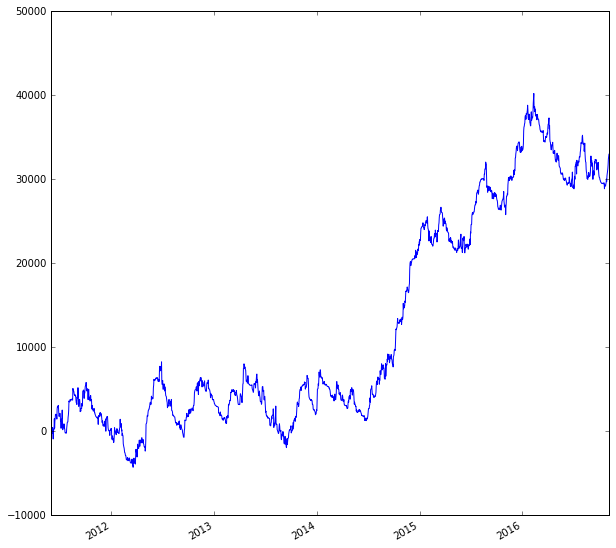

In [214]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information (obsolete)


## Costs information (per 1-exo unit)

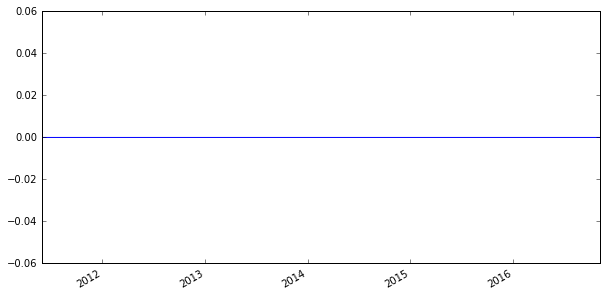

In [215]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

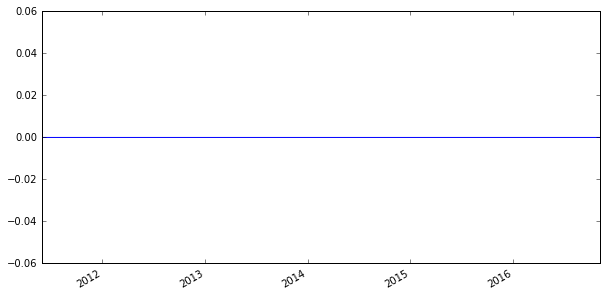

In [216]:
smgr.strategy.exoinfo.margin().plot()

# Saving results

In [217]:
smgr.save('./swarms/')

In [218]:
smgr.raw_swarm#.plot()

,"(1, 10, 1, 0)","(1, 10, 1, 1)","(1, 10, 5, 0)","(1, 10, 5, 1)","(1, 10, 7, 0)","(1, 10, 7, 1)","(1, 4, 1, 0)","(1, 4, 1, 1)","(1, 4, 5, 0)","(1, 4, 5, 1)",...,"(1, 6, 5, 0)","(1, 6, 5, 1)","(1, 6, 7, 0)","(1, 6, 7, 1)","(1, 8, 1, 0)","(1, 8, 1, 1)","(1, 8, 5, 0)","(1, 8, 5, 1)","(1, 8, 7, 0)","(1, 8, 7, 1)"
2011-06-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
